[*********************100%***********************]  1 of 1 completed

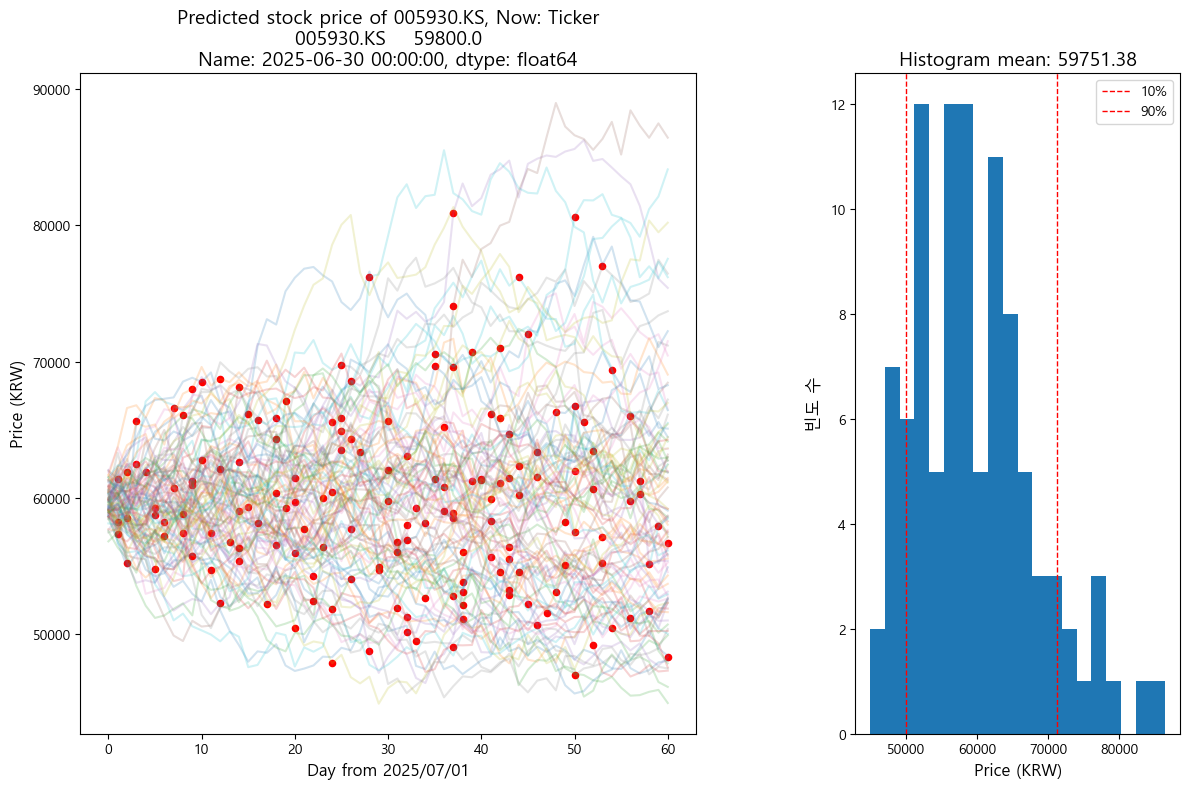

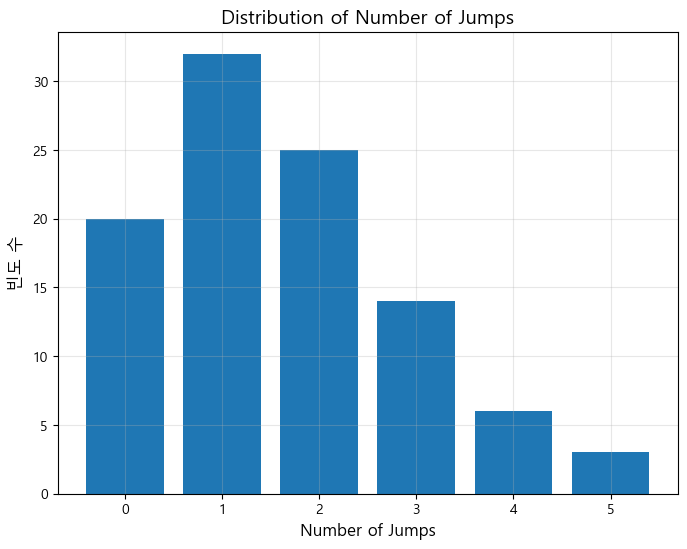

In [7]:
import yfinance as yf
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import warnings
warnings.filterwarnings('ignore')

# ✅ 한글 폰트 설정
def set_korean_font():
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = fm.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

# ✅ 주가 데이터 불러오기
def load_stock_data(ticker, months=18):
    today = date.today()
    startD = today - relativedelta(months=months)
    endD = today
    return yf.download(ticker, startD, endD)

# ✅ 수익률 평균과 표준편차 계산
def calc_return_stats(stock_data):
    returns = stock_data['Close'].pct_change().dropna()
    mu = returns.mean()
    sigma = returns.std()
    return mu, sigma

# ✅ 몬테카를로 시뮬레이션
def run_simulations(last_price, daily_vol, num_simulations=100, T=60, lambda_event=0.026, jump_vol=0.05):
    df = pd.DataFrame()
    last_price_list = []
    jump_indices_list = []  # 점프 발생 인덱스 리스트
    count_jump = []

    for _ in range(num_simulations):
        count = 0
        price_list = []
        price = last_price * (1 + np.random.normal(0, daily_vol))
        price_list.append(price)
        jump_indices = []  # 각 시뮬레이션별 점프 인덱스

        for t in range(T):
            event = np.random.poisson(lambda_event)
            if event == 1:
                jump_return = np.random.normal(0, jump_vol)
                price = price * (1 + jump_return)
                jump_indices.append(count + 1)  # 점프 발생 위치 기록
            else:
                price = price_list[count] * (1 + np.random.normal(0, daily_vol))
            price_list.append(price)
            count += 1

        df[len(df.columns)] = price_list
        last_price_list.append(price_list[-1])
        jump_indices_list.append(jump_indices)  # 점프 인덱스 저장
        count_jump.append(len(jump_indices))

    return df, last_price_list, jump_indices_list, count_jump

# ✅ 메인 함수 (종목코드 ticker를 인자로 받음)
def main(ticker):
    set_korean_font()
    stock_ticker = ticker
    stock_name = f'{ticker}'

    stock_data = load_stock_data(stock_ticker)
    mu, sigma = calc_return_stats(stock_data)
    last_price = stock_data['Close'].iloc[-1]

    # 시뮬레이션 실행
    price_df, last_price_list, jump_indices_list, count_jump = run_simulations(last_price, sigma)

    today = date.today()
    plt.figure(figsize=(12, 8))
    figL = plt.subplot2grid((1, 12), (0, 0), colspan=7)
    figR = plt.subplot2grid((1, 12), (0, 8), colspan=4)

    # 1) 주가 시뮬레이션 경로 + 점프 표시
    for i in range(min(100, price_df.shape[1])):
        figL.plot(price_df.iloc[:, i], alpha=0.2)
        jumps = jump_indices_list[i]
        if jumps:
            figL.scatter(jumps, [price_df.iloc[j, i] for j in jumps], color='red', s=20, marker='o', label='Jump' if i == 0 else "")
    handles, labels = figL.get_legend_handles_labels()
    if 'Jump' in labels:
        figL.legend()
    figL.set_title(f'Predicted stock price of {stock_name}, Now: {round(last_price, 2)}', fontsize=14)
    figL.set_xlabel(f'Day from {today.strftime('%Y/%m/%d')}', fontsize=12)
    figL.set_ylabel('Price (KRW)', fontsize=12)

    # 2) 마지막 가격 히스토그램 (기존과 동일)
    tem = [float(price) for price in last_price_list]
    figR.hist(tem, bins=20)
    figR.axvline(np.percentile(tem, 10), color='r', linestyle='dashed', linewidth=1, label='10%')
    figR.axvline(np.percentile(tem, 90), color='r', linestyle='dashed', linewidth=1, label='90%')
    str_mean = str(round(np.mean(tem), 2))
    figR.set_title('Histogram mean: ' + str_mean, fontsize=14)
    figR.set_xlabel('Price (KRW)', fontsize=12)
    figR.set_ylabel('빈도 수', fontsize=12)
    figR.legend()
    plt.tight_layout()
    plt.show()
    
    # 점프 횟수 분포 시각화
    plt.figure(figsize=(8, 6))
    plt.hist(count_jump, bins=range(min(count_jump), max(count_jump) + 2, 1), 
            align='left', rwidth=0.8)
    plt.title('Distribution of Number of Jumps', fontsize=14)
    plt.xlabel('Number of Jumps', fontsize=12)
    plt.ylabel('빈도 수', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()



# ✅ 실행
if __name__ == "__main__":
    main('005930.KS')  # ← 여기만 바꾸면 종목코드 변경 가능